In [47]:
# --- 0. Imports ---

# Import all the libraries you'll need at the top.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

# Imbalanced Data Handling
from imblearn.over_sampling import SMOTE
# Use the imblearn pipeline to correctly apply SMOTE during CV
from imblearn.pipeline import Pipeline as ImbPipeline 

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Evaluation
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    f1_score,
    roc_curve,
    precision_recall_curve
)


# Settings
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')

In [ ]:
Dataset = pd.read_csv("E:\\Work\\College_works\\Competitions\\ModelX\\Dataset-20251115T054810Z-1-001\\Dataset\\Dementia Prediction Dataset.csv", low_memory=False)

print(list(Dataset))


['NACCID', 'NACCADC', 'PACKET', 'FORMVER', 'VISITMO', 'VISITDAY', 'VISITYR', 'NACCVNUM', 'NACCAVST', 'NACCNVST', 'NACCDAYS', 'NACCFDYS', 'NACCCORE', 'NACCREAS', 'NACCREFR', 'BIRTHMO', 'BIRTHYR', 'SEX', 'HISPANIC', 'HISPOR', 'HISPORX', 'RACE', 'RACEX', 'RACESEC', 'RACESECX', 'RACETER', 'RACETERX', 'PRIMLANG', 'PRIMLANX', 'EDUC', 'MARISTAT', 'NACCLIVS', 'INDEPEND', 'RESIDENC', 'HANDED', 'INBIRMO', 'INBIRYR', 'INSEX', 'NEWINF', 'INHISP', 'INHISPOR', 'INHISPOX', 'NACCNINR', 'INRACE', 'INRACEX', 'INRASEC', 'INRASECX', 'INRATER', 'INRATERX', 'INEDUC', 'INRELTO', 'INRELTOX', 'INKNOWN', 'INLIVWTH', 'INVISITS', 'INCALLS', 'INRELY', 'NACCFAM', 'NACCMOM', 'NACCDAD', 'NACCAM', 'NACCAMX', 'NACCAMS', 'NACCAMSX', 'NACCFM', 'NACCFMX', 'NACCFMS', 'NACCFMSX', 'NACCOM', 'NACCOMX', 'NACCOMS', 'NACCOMSX', 'NACCFADM', 'NACCFFTD', 'ANYMEDS', 'DRUG1', 'DRUG2', 'DRUG3', 'DRUG4', 'DRUG5', 'DRUG6', 'DRUG7', 'DRUG8', 'DRUG9', 'DRUG10', 'DRUG11', 'DRUG12', 'DRUG13', 'DRUG14', 'DRUG15', 'DRUG16', 'DRUG17', 'DRUG18'

In [49]:
# --- Target and Feature Separation ---
# Target Variable: DEMENTED 
Y = Dataset[['DEMENTED']]
X = Dataset.drop(columns=[['DEMENTED']], errors='ignore')

# --- Simple Feature Engineering (FAQ Score) ---
# Create the most powerful feature: the sum of the Functional Activities Questionnaire (FAQ).
faq_cols = ['BILLS', 'TAXES', 'SHOPPING', 'GAMES', 'STOVE', 
            'MEALPREP', 'EVENTS', 'PAYATTN', 'REMDATES', 'TRAVEL']
existing_faq_cols = [col for col in faq_cols if col in X.columns]

# Impute raw FAQ columns with 0, then sum them up.
faq = X[existing_faq_cols].fillna(0).sum(axis=1)

# Remove the raw FAQ variables to prevent multicollinearity and simplify the final feature set
X = X.drop(columns=existing_faq_cols, errors='ignore')

display(X)

,NACCID,NACCADC,PACKET,FORMVER,VISITMO,VISITDAY,VISITYR,NACCVNUM,NACCAVST,NACCNVST,...,NPATGAM1,NPATGAM2,NPATGAM3,NPATGAM4,NPATGAM5,NPATGFRN,NPATGFR1,NPATGFR2,NPATGFR3,NPATGFR4
0,NACC002909,186,I,3.0,12,28,2022,1,2,2,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
1,NACC002909,186,F,3.0,1,23,2024,2,2,2,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
2,NACC003487,186,I,3.0,11,15,2023,1,1,1,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
3,NACC004352,186,I,3.0,10,5,2021,1,1,1,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
4,NACC004687,186,I,3.0,11,14,2022,1,1,1,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195191,NACC998475,9661,F,2.0,11,6,2008,3,3,3,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
195192,NACC999391,9661,I,1.0,3,2,2006,1,3,3,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
195193,NACC999391,9661,F,1.0,5,17,2007,2,3,3,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
195194,NACC999391,9661,F,2.0,3,27,2008,3,3,3,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4


In [50]:
# --- Column Selection ---
columns_to_keep = [
    "NACCIQ",
  "NACCADC",
  "PACKET",
  "FORMVER",
  "VISMID",
  "VISITDAY",
  "VISITYR",
  "NACCNIHM",
  "NACCAVST",
  "NACCNVST",
  "NACCDAYS",
  "NACCFOYS",
  "NACCCDED",
  "NACCMOD",
  "NACCYOD",
  "NACCACTV",
  "NACCDNVS",
  "NACCDMSO",
  "NACCDSYD",
  "NACCD5YR",
  "NACCNPUR",
  "NACCNRMO",
  "NACCNRDY",
  "NACCMRXR",
  "NACCM5DS",
  "NACCAPOE",
  "TELCOV",
  "TELMOD",
  "NACCREAS",
  "NACCREFR",
  "BIRTHMO",
  "BIRTHYR",
  "SEX",
  "HISPANIC",
  "HISPOR",
  "HISPORX",
  "RACE",
  "RACESEC",
  "RACESX",
  "RACETER",
  "RACETERX",
  "PRIMLANG",
  "PRIMLANX",
  "EDUC",
  "MARISTAT",
  "NACCNIDS",
  "INDEPEND",
  "RESIDENC",
  "LIVSIT",
  "NACCAGE",
  "NACCAGEB",
  "NACCAHRC",
  "INBIRMO",
  "INBIRYR",
  "INSEX",
  "NEWINF",
  "INHISP",
  "INHISPOX",
  "INRACE",
  "INRASEC",
  "INRASECX",
  "INRATER",
  "INRATERX",
  "INEDUC",
  "INRELTO",
  "INKNOWN",
  "INLIVWITH",
  "INVISITS",
  "INCALLS",
  "INREL",
  "NACCNINR",
  "NACCFAM",
  "NACCMOM",
  "NACCDAD",
  "NACCAM",
  "NACCAMS",
  "NACCFM",
  "NACCFMX",
  "NACCFMS",
  "NACCFMSX",
  "NACCOM",
  "NACCOMX",
  "NACCOMS",
  "NACCOMSX"
]
#new feature for FAQ score
X = X[ [c for c in columns_to_keep if c in X.columns] ]
X['FAQ_SCORE'] = faq

# numeric_features = [
#     'BIRTHYR', 'EDUC', 'NACCAGEB', 'INBIRYR', 'INEDUC', 'INKNOWN', 
#     'FAQ_SCORE'
# ]
#Get the categoricat features
# all_cols_remaining = X.columns.tolist()
# categorical_features = [col for col in all_cols_remaining if col not in numeric_features]
# display(categorical_features)


In [51]:
#columns which are not float or int
non_num_cols = X.select_dtypes(exclude=['float', 'int'])
display(non_num_cols.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195196 entries, 0 to 195195
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   PACKET    195196 non-null  object
 1   HISPORX   527 non-null     object
 2   RACETERX  36 non-null      object
 3   PRIMLANX  2732 non-null    object
 4   INHISPOX  238 non-null     object
 5   INRASECX  297 non-null     object
 6   INRATERX  59 non-null      object
 7   NACCFMX   25356 non-null   object
 8   NACCFMSX  25348 non-null   object
 9   NACCOMX   25686 non-null   object
 10  NACCOMSX  13727 non-null   object
dtypes: object(11)
memory usage: 16.4+ MB


None

In [ ]:
#filling null values
# X["RACETERX"] = X["RACETERX"].fillna('not specified')
# X["HISPORX"] = X["HISPORX"].fillna('Not applicable')
# X["PRIMLANX"] = X["PRIMLANX"].fillna('Not applicable')
# X["INHISPOX"] = X["INHISPOX"].fillna('Not applicable')
# X["INRASECX"] = X["INRASECX"].fillna('Not applicable')
# X["INRATERX"] = X["INRATERX"].fillna('Not applicable')
# X["NACCFMX"] = X["NACCFMX"].fillna('Not applicable')
# X["NACCFMSX"] = X["NACCFMSX"].fillna('Not applicable')
# X["NACCOMX"] = X["NACCOMX"].fillna('Not applicable')
# X["NACCOMSX"] = X["NACCOMSX"].fillna('Not applicable')

# --- Identify numeric and categorical columns ---
numeric_features = X.select_dtypes(include=['float', 'int']).columns.tolist()
categorical_features = X.select_dtypes(exclude=['float', 'int']).columns.tolist()

# --- Numeric: Impute median and scale ---
num_imputer = SimpleImputer(strategy='median')
X[numeric_features] = num_imputer.fit_transform(X[numeric_features])

scaler = StandardScaler()
X[numeric_features] = scaler.fit_transform(X[numeric_features])

# --- Categorical: Impute most frequent ---
cat_imputer = SimpleImputer(strategy='most_frequent')
X[categorical_features] = cat_imputer.fit_transform(X[categorical_features])

In [53]:
#Checking the null (num + cate)
cols_with_nulls = X.columns[X.isnull().any()]
display(cols_with_nulls)

Index([], dtype='object')

In [54]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)


Get the categorical features

In [55]:
#categorical features
cat_features = [col for col in X_train.columns if X_train[col].dtype == 'object']
display(cat_features)

['PACKET',
 'HISPORX',
 'RACETERX',
 'PRIMLANX',
 'INHISPOX',
 'INRASECX',
 'INRATERX',
 'NACCFMX',
 'NACCFMSX',
 'NACCOMX',
 'NACCOMSX']

Mutual Information

--> This code selects the most important features using Mutual Information (MI) and keeps only the top 50% most informative features.

--> Mutual Information tells how much knowing a feature reduces uncertainty about the target

In [56]:
#LabelEncoder: Used to convert categorical text values into numeric values.
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
# MI requires numeric features, so you must encode categorical features temporarily.
X_temp = X_train.copy()

#Each column in cat_features is label-encoded.
for col in cat_features:
    X_temp[col] = LabelEncoder().fit_transform(X_temp[col])

#Returns a list of MI scores.
#Higher score = feature is more informative.
mi_scores = mutual_info_classif(X_temp, y_train)

#Maps each score to its feature name.
#Sorts features from highest MI → lowest.
mi = pd.Series(mi_scores, index=X_train.columns).sort_values(ascending=False)

# Keep top 50% MI features
top_mi_features = mi.head(len(mi)//2).index.tolist()

#modify the train and test sections
X_train_mi = X_train[top_mi_features]
X_test_mi  = X_test[top_mi_features]
display(X_train_mi)

,FAQ_SCORE,INDEPEND,NACCDAYS,NACCYOD,NACCMOD,NACCACTV,NACCNVST,NACCREFR,RESIDENC,NACCAM,...,INRATERX,HISPORX,RACETERX,INRASECX,NACCOMSX,INHISPOX,NACCFMSX,EDUC,FORMVER,MARISTAT
134508,-0.497323,-0.554349,-0.104648,0.648384,0.647510,0.847671,-0.195875,-0.813356,-0.266453,1.061736,...,Irish,Spain,Irish,Jewish,.,Spain,.,0.003707,0.922429,-0.602548
24817,-0.497323,-0.554349,-0.449410,0.648384,0.647510,-0.821369,-0.448679,-0.813356,-0.266453,1.061736,...,Irish,Spain,Irish,Jewish,.,Spain,.,0.451416,1.208862,-0.602548
8889,0.770638,7.723870,-1.368965,-1.541250,-1.552416,-0.821369,-1.207090,1.816666,-0.266453,1.061736,...,Irish,Spain,Irish,Jewish,.,Spain,.,1.197598,0.922429,-0.602548
9501,1.277822,1.515206,-1.077632,0.648384,0.647510,-0.821369,-0.954286,-0.484604,1.552289,-1.171373,...,Irish,Spain,Irish,Jewish,.,Spain,.,-0.593239,-1.941898,0.172193
32891,-0.497323,-0.554349,0.080388,0.648384,0.647510,-0.821369,0.056929,-0.813356,-0.266453,1.061736,...,Irish,Spain,Irish,Jewish,.,Spain,.,0.600652,0.922429,0.946934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40061,0.960832,0.480429,-1.368965,0.648384,0.647510,0.847671,-1.207090,-0.484604,-0.266453,1.061736,...,Irish,Spain,Irish,Jewish,.,Spain,.,0.003707,0.922429,-0.602548
150882,0.390249,-0.554349,-0.453347,0.648384,0.647510,-0.821369,-0.195875,-0.484604,-0.266453,-0.484263,...,Irish,Spain,Irish,Jewish,.,Spain,.,0.003707,0.922429,-0.602548
66239,0.897434,0.480429,2.154026,0.648384,0.647510,0.847671,2.837769,1.487913,0.642918,1.061736,...,Irish,Spain,Irish,Jewish,.,Spain,.,0.302179,0.922429,-0.602548
31250,1.341220,1.515206,-1.368965,-1.542206,-1.632901,-0.821369,-1.207090,-0.484604,-0.266453,-1.171373,...,Irish,Spain,Irish,Jewish,.,Spain,.,0.302179,-0.509734,-0.602548


Remove Highly Correlated Features (Feature selection)

In [57]:
import matplotlib.pyplot as plt

corr_matrix = X_train_mi.corr(numeric_only=True).abs()
display(corr_matrix)

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

X_train_filtered = X_train_mi.drop(columns=to_drop, errors='ignore')
X_test_filtered  = X_test_mi.drop(columns=to_drop, errors='ignore')
display(X_train_filtered)

,FAQ_SCORE,INDEPEND,NACCDAYS,NACCYOD,NACCMOD,NACCACTV,NACCNVST,NACCREFR,RESIDENC,NACCAM,...,INRELTO,NACCFMS,NACCAMS,NACCADC,NACCOMS,NACCAPOE,INVISITS,EDUC,FORMVER,MARISTAT
FAQ_SCORE,1.000000,0.526465,0.192622,0.260456,0.260527,0.191564,0.221746,0.106056,0.080194,0.138128,...,0.198890,0.122929,0.122719,0.051988,0.122358,0.036678,0.329403,0.043472,0.079551,0.114576
INDEPEND,0.526465,1.000000,0.207783,0.355466,0.355276,0.222300,0.251214,0.076553,0.216037,0.180249,...,0.052444,0.148351,0.149850,0.064424,0.148021,0.073695,0.035161,0.012862,0.080335,0.058949
NACCDAYS,0.192622,0.207783,1.000000,0.046738,0.046444,0.245572,0.898383,0.150267,0.012152,0.414691,...,0.032524,0.362422,0.360283,0.196895,0.363774,0.261791,0.042365,0.032297,0.087902,0.015958
NACCYOD,0.260456,0.355466,0.046738,1.000000,0.998647,0.531477,0.040414,0.014765,0.133130,0.163677,...,0.049955,0.120549,0.120707,0.072085,0.120639,0.037645,0.039637,0.009362,0.261229,0.055969
NACCMOD,0.260527,0.355276,0.046444,0.998647,1.000000,0.530760,0.040370,0.013978,0.132872,0.163335,...,0.049604,0.120188,0.120424,0.072298,0.120237,0.037296,0.039473,0.009206,0.260833,0.055990
NACCACTV,0.191564,0.222300,0.245572,0.531477,0.530760,1.000000,0.193999,0.050041,0.093944,0.323656,...,0.030397,0.234947,0.235327,0.101462,0.234565,0.040264,0.032967,0.041024,0.411443,0.030733
NACCNVST,0.221746,0.251214,0.898383,0.040414,0.040370,0.193999,1.000000,0.143338,0.037705,0.339340,...,0.025388,0.298077,0.297036,0.203336,0.299637,0.263054,0.048679,0.025892,0.020212,0.017160
NACCREFR,0.106056,0.076553,0.150267,0.014765,0.013978,0.050041,0.143338,1.000000,0.077985,0.021899,...,0.001366,0.003592,0.002322,0.091349,0.002777,0.029189,0.078553,0.007451,0.115555,0.047443
RESIDENC,0.080194,0.216037,0.012152,0.133130,0.132872,0.093944,0.037705,0.077985,1.000000,0.071519,...,0.006802,0.047467,0.050182,0.033030,0.047734,0.037619,0.188093,0.019533,0.076817,0.088362
NACCAM,0.138128,0.180249,0.414691,0.163677,0.163335,0.323656,0.339340,0.021899,0.071519,1.000000,...,0.060755,0.945615,0.967404,0.002328,0.940134,0.119777,0.051296,0.052435,0.477127,0.008982


,FAQ_SCORE,INDEPEND,NACCDAYS,NACCYOD,NACCACTV,NACCREFR,RESIDENC,NACCAM,INCALLS,NACCREAS,...,INRATERX,HISPORX,RACETERX,INRASECX,NACCOMSX,INHISPOX,NACCFMSX,EDUC,FORMVER,MARISTAT
134508,-0.497323,-0.554349,-0.104648,0.648384,0.847671,-0.813356,-0.266453,1.061736,0.764818,-0.372978,...,Irish,Spain,Irish,Jewish,.,Spain,.,0.003707,0.922429,-0.602548
24817,-0.497323,-0.554349,-0.449410,0.648384,-0.821369,-0.813356,-0.266453,1.061736,0.764818,-0.372978,...,Irish,Spain,Irish,Jewish,.,Spain,.,0.451416,1.208862,-0.602548
8889,0.770638,7.723870,-1.368965,-1.541250,-0.821369,1.816666,-0.266453,1.061736,0.764818,-0.372978,...,Irish,Spain,Irish,Jewish,.,Spain,.,1.197598,0.922429,-0.602548
9501,1.277822,1.515206,-1.077632,0.648384,-0.821369,-0.484604,1.552289,-1.171373,-0.690940,3.686188,...,Irish,Spain,Irish,Jewish,.,Spain,.,-0.593239,-1.941898,0.172193
32891,-0.497323,-0.554349,0.080388,0.648384,-0.821369,-0.813356,-0.266453,1.061736,-0.690940,-0.372978,...,Irish,Spain,Irish,Jewish,.,Spain,.,0.600652,0.922429,0.946934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40061,0.960832,0.480429,-1.368965,0.648384,0.847671,-0.484604,-0.266453,1.061736,0.764818,-0.372978,...,Irish,Spain,Irish,Jewish,.,Spain,.,0.003707,0.922429,-0.602548
150882,0.390249,-0.554349,-0.453347,0.648384,-0.821369,-0.484604,-0.266453,-0.484263,0.764818,-0.372978,...,Irish,Spain,Irish,Jewish,.,Spain,.,0.003707,0.922429,-0.602548
66239,0.897434,0.480429,2.154026,0.648384,0.847671,1.487913,0.642918,1.061736,0.764818,-0.372978,...,Irish,Spain,Irish,Jewish,.,Spain,.,0.302179,0.922429,-0.602548
31250,1.341220,1.515206,-1.368965,-1.542206,-0.821369,-0.484604,-0.266453,-1.171373,0.764818,-0.372978,...,Irish,Spain,Irish,Jewish,.,Spain,.,0.302179,-0.509734,-0.602548


Train a Model for Feature Importance (CatBoost): Feature selection

In [58]:
from catboost import CatBoostClassifier, Pool
# Identify categorical again after filtering
cat_features_filtered = [col for col in X_train_filtered.columns 
                         if X_train_filtered[col].dtype == 'object']
#catboost model
model = CatBoostClassifier(
    eval_metric='AUC',
    learning_rate=0.05,
    depth=6,
    iterations=600,
    verbose=False
)
#fit the model
model.fit(
    X_train_filtered, y_train,
    cat_features=cat_features_filtered,
    eval_set=(X_test_filtered, y_test)
)


Model-Based Feature Importance

In [59]:
importances = model.get_feature_importance()
feature_importance = pd.Series(importances, index=X_train_filtered.columns)
feature_importance.sort_values(ascending=False).head(20)

FAQ_SCORE    34.491098
INDEPEND     20.130407
NACCADC      13.305983
NACCDAYS      7.912812
NACCREFR      4.600732
NACCYOD       3.782962
NACCAPOE      3.110575
NACCREAS      2.697301
INRELTO       2.222499
NACCACTV      1.738655
EDUC          1.431518
MARISTAT      1.032412
NACCAM        0.921233
FORMVER       0.881957
INCALLS       0.721261
RESIDENC      0.637927
PRIMLANX      0.193086
NACCOMSX      0.087234
HISPORX       0.038688
RACETERX      0.032143
dtype: float64

Select Top 10–25 Features

In [60]:
selected_features = feature_importance.head(20).index.tolist()

X_train_final = X_train_filtered[selected_features]
X_test_final = X_test_filtered[selected_features]

Model training & creation

In [62]:
from lightgbm import LGBMClassifier

final_model = LGBMClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary',
    boosting_type='gbdt'
)

# Identify object columns
object_cols = X_train_final.select_dtypes(include=['object']).columns

# Convert them to category dtype
for col in object_cols:
    X_train_final[col] = X_train_final[col].astype('category')
for col in object_cols:
    X_test_final[col] = X_test_final[col].astype('category')


# Train the model
final_model.fit(X_train_final, y_train)

[LightGBM] [Info] Number of positive: 46072, number of negative: 110084
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 699
[LightGBM] [Info] Number of data points in the train set: 156156, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.295038 -> initscore=-0.871038
[LightGBM] [Info] Start training from score -0.871038


LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, n_estimators=600,
               objective='binary', subsample=0.8)

In [63]:
#predict
y_pred_prob = final_model.predict_proba(X_test_final)[:, 1] * 100
display(y_pred_prob)

array([94.591217  , 99.51081931,  4.21571847, ...,  1.52008674,
        0.17548068, 80.54660652])

Model evaluation

In [65]:
#Classification report
y_pred = (y_pred_prob >= 0.5).astype(int)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.47      0.64     27522
           1       0.44      1.00      0.61     11518

    accuracy                           0.62     39040
   macro avg       0.72      0.73      0.62     39040
weighted avg       0.83      0.62      0.63     39040



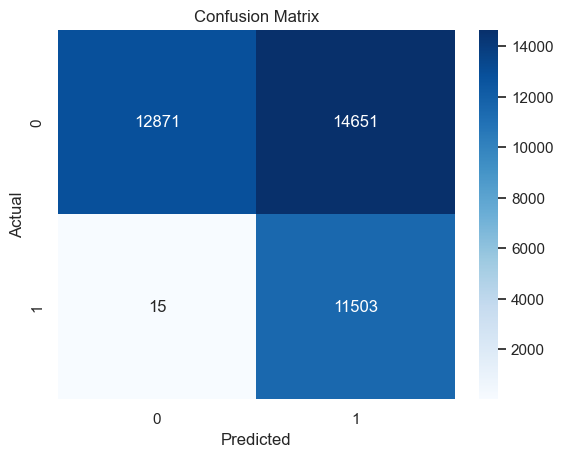

In [67]:
#Confiusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=final_model.classes_,
            yticklabels=final_model.classes_)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

AUC: 0.7332


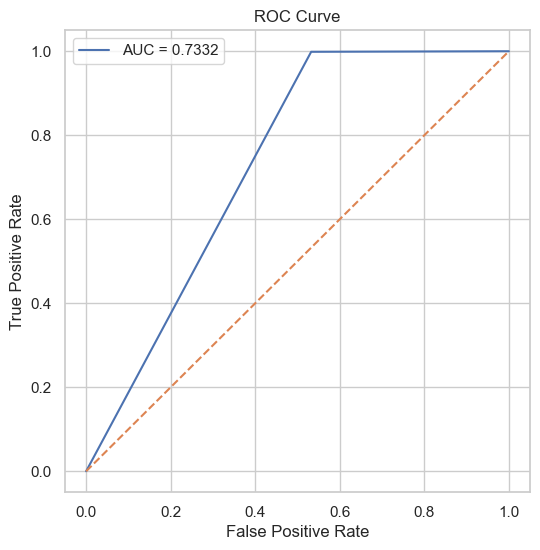

In [68]:
#ROC and AUC
# Compute ROC values
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

auc_value = roc_auc_score(y_test, y_pred)
print(f"AUC: {auc_value:.4f}")

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_value:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')  # diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Compute Log Loss
from sklearn.metrics import log_loss

logloss_value = log_loss(y_test, y_pred_prob)
print("Log Loss:", logloss_value)

Log Loss: 10.896818771298602


In [71]:
#Brier Score
from sklearn.metrics import brier_score_loss
y_pred_prob_clip = np.clip(y_pred_prob, 0, 1)
brier = brier_score_loss(y_test, y_pred_prob_clip)
print("Brier Score:", brier)

Brier Score: 0.35641516476588136


Visualizations

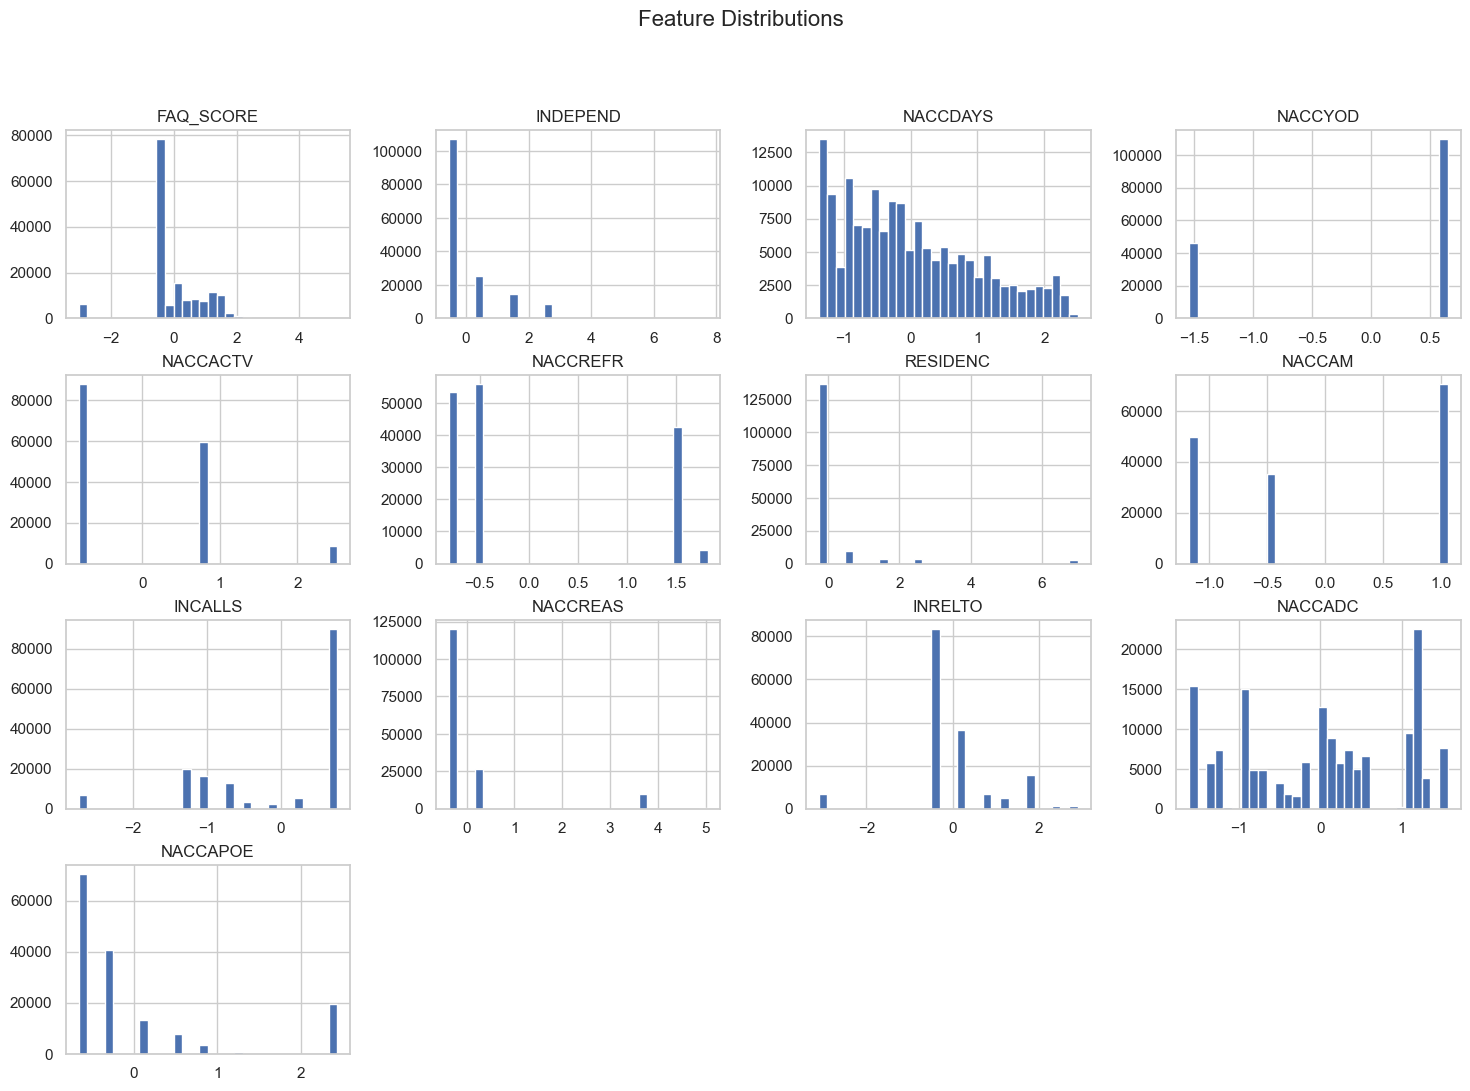

In [72]:
X_train_final.hist(figsize=(18,12), bins=30)
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()


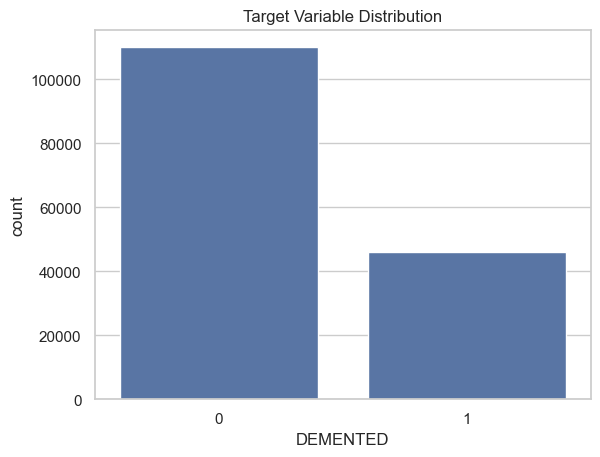

In [ ]:
y_train_series = pd.Series(y_train.squeeze())

sns.countplot(x=y_train_series)
plt.title("Target Variable Distribution")
plt.show()


Patt Callibration

In [92]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_lgbm = CalibratedClassifierCV(final_model, method='sigmoid', cv=5)
calibrated_lgbm.fit(X_train_final, y_train)


[LightGBM] [Info] Number of positive: 36857, number of negative: 88067
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 664
[LightGBM] [Info] Number of data points in the train set: 124924, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.295035 -> initscore=-0.871052
[LightGBM] [Info] Start training from score -0.871052
[LightGBM] [Info] Number of positive: 36858, number of negative: 88067
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 124925, number of used features: 20
[LightGBM] [Info] 

CalibratedClassifierCV(cv=5,
                       estimator=LGBMClassifier(colsample_bytree=0.8,
                                                learning_rate=0.05,
                                                n_estimators=600,
                                                objective='binary',
                                                subsample=0.8))

In [94]:
y_prob = calibrated_lgbm.predict_proba(X_test_final)[:, 1] * 100
display(y_prob)

array([95.09259039, 96.75227802,  2.6368512 , ...,  2.34872397,
        2.11102453, 88.8138401 ])

Model intepretation

In [98]:
#Permutation Importance
from sklearn.inspection import permutation_importance
result = permutation_importance(
    final_model, 
    X_train_final, 
    y_train, 
    scoring='roc_auc',
    n_repeats=3,
    random_state=42,
    n_jobs=-1
)

perm_importance = pd.Series(result.importances_mean, index=X_train_final.columns)
perm_importance.sort_values(ascending=False).head(20)
display(perm_importance)

FAQ_SCORE    0.158349
INDEPEND     0.032753
NACCDAYS     0.008479
NACCYOD      0.002595
NACCACTV     0.001283
NACCREFR     0.002441
RESIDENC     0.000538
NACCAM       0.000862
INCALLS      0.001230
NACCREAS     0.001669
INRELTO      0.001781
NACCADC      0.010738
PRIMLANX     0.000260
NACCAPOE     0.002470
INRATERX     0.000000
HISPORX      0.000010
RACETERX     0.000000
INRASECX     0.000017
NACCOMSX     0.000049
INHISPOX     0.000006
dtype: float64

Second model (catBoost)

In [100]:
cat_features_filtered_catBoost = [
    X_train_final.columns.get_loc(col)
    for col in X_train_final.columns
    if X_train_final[col].dtype == 'object' or str(X_train_final[col].dtype) == 'category'
]
display(cat_features_filtered_catBoost)

[12, 14, 15, 16, 17, 18, 19]

In [101]:
model = CatBoostClassifier(
    iterations=800,
    depth=6,
    learning_rate=0.05,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=False
)

model.fit(
    X_train_final, y_train,
    cat_features=cat_features_filtered_catBoost,
    eval_set=(X_test_final, y_test),
    verbose=False
)


In [103]:
y_pred_class = model.predict(X_test_final)
y_pred_prob  = model.predict_proba(X_test_final)[:, 1]  # probability of dementia risk
display(y_pred_prob)

array([0.93952616, 0.99278649, 0.03910204, ..., 0.01253534, 0.00205059,
       0.8254021 ])

In [106]:
print("Classification report: \n" + classification_report(y_test, y_pred_class))

Classification report: 
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     27522
           1       0.88      0.87      0.87     11518

    accuracy                           0.93     39040
   macro avg       0.91      0.91      0.91     39040
weighted avg       0.93      0.93      0.93     39040



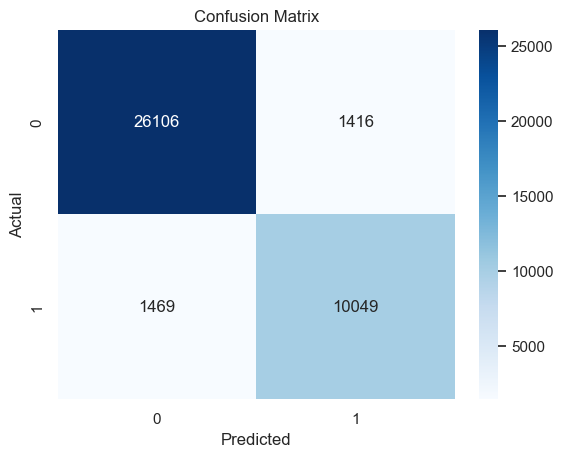

In [105]:
cm = confusion_matrix(y_test, y_pred_class)

sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
